In [1]:
import os
import pickle
import time
from collections import Counter

import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import (ELU, Activation, BatchNormalization, Conv2D, Dense,
                          Dropout, Flatten, LeakyReLU, MaxPooling2D, Reshape)
from keras.optimizers import SGD, Nadam, RMSprop
from keras.regularizers import l2
from keras.utils.generic_utils import get_custom_objects
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import (BatchNormalization, Dense, Dropout,
                                     LeakyReLU)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2

from hex import HexGame
from mcts import Mcts
from neuralnet import createModel, loadModel
from player import MCTSPlayer, NeuralMCTSPlayer, NeuralNetPlayer, RandomPlayer
from tournament import Tournament

tf.config.run_functions_eagerly(True)

### Load data

In [27]:
boardSize = 7
gameTime = 300
epsilonMultiplier = 0.995
batchSize = 128
epochs = 5
folder = f"{boardSize}b {gameTime}s {epsilonMultiplier}e {batchSize}m {epochs}t"

In [28]:
# load model with most iterations
highest = 0
for file in os.listdir(folder):
    if file.startswith("model"):
        num = int(file.split(".")[1][:-1])
        if num > highest:
            highest = num
model = loadModel(folder + "/model." + str(highest)+"e")
print("Loaded model with", highest, "iterations")

# load metrics.pickle in folder
with open(folder + "/metrics.pickle", "rb") as f:
    metrics = pickle.load(f)
    print("Loaded metrics")

# load replay buffer
with open(folder + "/replayBuffer.pickle", "rb") as f:
    replayBuffer = pickle.load(f)
    print("Loaded replay buffer with", len(replayBuffer), "state-action pairs")

Loaded model with 210 iterations
Loaded metrics
Loaded replay buffer with 4900 state-action pairs


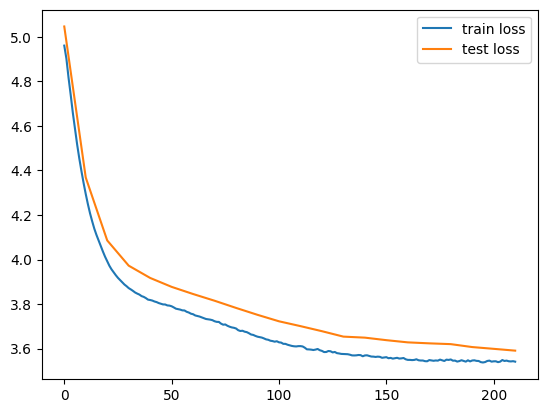

Final test loss: 3.5908188819885254
Slope of last 100 points: -0.3900940643064989 %


In [29]:
trainLoss, trainAccuracy, testLoss, testAccuracy, randomWinrate = metrics
# train is sampled every iteration, but test is sampled every 10 iterations
testX = np.arange(0, len(testLoss)*10, 10)
randomWinrateX = np.arange(0, len(randomWinrate)*10, 10)

# plot losses
plt.plot(trainLoss, label="train loss")
plt.plot(testX, testLoss, label="test loss")
plt.legend()
plt.show()
print("Final test loss:", testLoss[-1])
# fit best fit line on last 100 points
m, b = np.polyfit(testX[-100:], testLoss[-100:], 1)
print("Slope of last 100 points:", m*100, "%")

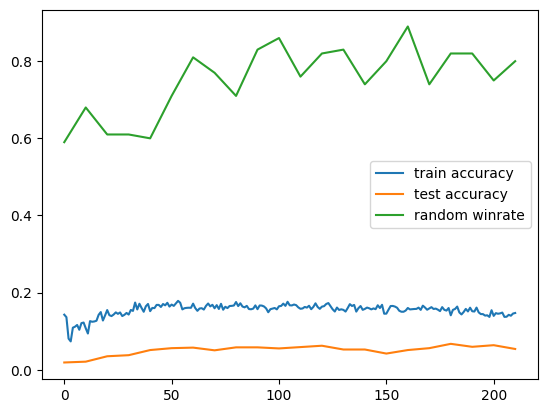

Final test accuracy: 0.053921569138765335
Final random winrate: 0.8
Slope of last 100 points: 0.012866807170738116 %


In [30]:
# plot accuracy and winrate
plt.plot(trainAccuracy, label="train accuracy")
plt.plot(testX, testAccuracy, label="test accuracy")
plt.plot(randomWinrateX, randomWinrate, label="random winrate")
plt.legend()
plt.show()
print("Final test accuracy:", testAccuracy[-1])
print("Final random winrate:", randomWinrate[-1])
# fit best fit line on last 100 points
m, b = np.polyfit(testX[-100:], testAccuracy[-100:], 1)
print("Slope of last 100 points:", m*100, "%")

### Create training set

In [31]:
x_buffer, y_buffer = [], []
for x, y in replayBuffer:
    x_buffer.append(tf.squeeze(x, axis=0))
    y_buffer.append(y)

x_train = tf.stack(x_buffer, axis=0)
y_train = tf.convert_to_tensor(y_buffer, dtype=tf.float32)

### Create test set

In [32]:
def createTest(timePerMove, runs):
    # simulate games to create test set
    mctsPlayer = MCTSPlayer(maxIters=500, maxTime=timePerMove, argmax=False)
    tournament = Tournament(HexGame, [mctsPlayer, mctsPlayer], boardSize=boardSize, plot=False)
    tournament.run(runs)
    replayBuffer = mctsPlayer.mcts.replayBuffer
    x_buffer, y_buffer = [], []
    for x, y in replayBuffer:
        x_buffer.append(tf.squeeze(x, axis=0))
        y_buffer.append(y)

    x_test = tf.stack(x_buffer, axis=0)
    y_test = tf.convert_to_tensor(y_buffer, dtype=tf.float32)
    print("Test set size:", len(x_test))

    # save test set to pickle
    with open(f'testSet{boardSize}.pickle', 'wb') as f:
        pickle.dump((x_test, y_test), f)

# increase for better validation accuracy
# createTest(2.0, 20)

In [33]:
# load test set from pickle
with open(f'testSet{boardSize}.pickle', 'rb') as f:
    x_test, y_test = pickle.load(f)

### Baseline accuracy in train

In [34]:
# calculate baseline accuracy by predicting the most common move on validation set
mostCommonMove = Counter([np.argmax(x) for x in x_train]).most_common(1)[0][0]
baselineAccuracy = sum([np.argmax(y) == mostCommonMove for y in y_test])/len(y_test)
print(f"Baseline accuracy: {baselineAccuracy:.5f}, with most common move {mostCommonMove}")

Baseline accuracy: 0.01681, with most common move 1


In [35]:
def createModel(size):
    input_shape = (4, size, size)
    output_shape = size * size
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3, 3), padding='same', input_shape=input_shape, kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(output_shape, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    return model

Best validation accuracy: 0.0819
Best validation loss: 3.5263


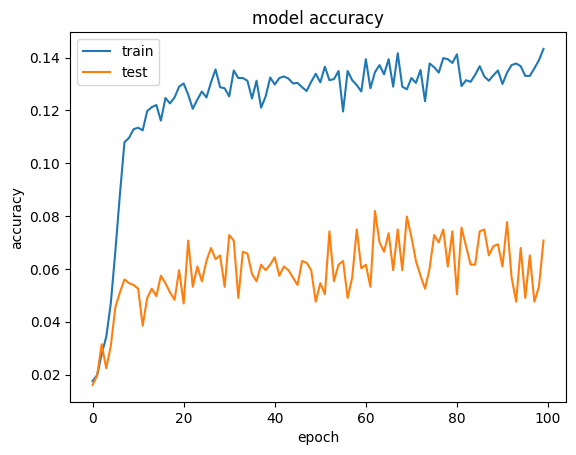

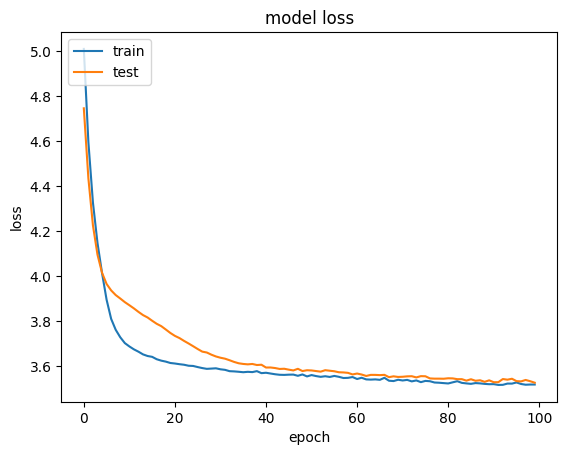

In [37]:
newModel = createModel(boardSize)
history = newModel.fit(x_train, y_train, epochs=100, batch_size=batchSize*2, validation_data=(x_test, y_test), verbose=0, shuffle=True)
bestValAcc = max(history.history['val_accuracy'])
bestValLoss = min(history.history['val_loss'])
print("Best validation accuracy:", round(bestValAcc,4))
print("Best validation loss:", round(bestValLoss,4))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Test NN vs mcts

In [62]:
# test if neuralnet alone is better than mcts
mctsPlayer = MCTSPlayer(maxIters=10000, maxTime=0.1, argmax=True)
nnPlayer = NeuralNetPlayer(model=model, argmax=True)
tournament = Tournament(HexGame, [nnPlayer, mctsPlayer], boardSize=boardSize, plot=False)
tournament.run(1)
tournament.printResults()

3 3 3 2 5 5 6 4 5 6 7 5 7 6 6 6 9 16 3 2 3 2 4 5 3 3 5 4 4 5 6 5 5 8 11 16 22 17 18 37 Starting player won 1 times and lost 1 times
NeuralNet won 0 times, lost 2 times, and drew 0 times
MCTS won 2 times, lost 0 times, and drew 0 times


In [63]:
# test nnMctsPlayer is better than mctsPlayer for same time restriction
mctsPlayer = MCTSPlayer(maxIters=10000, maxTime=0.1, argmax=True)
nnMctsPlayer = NeuralMCTSPlayer(model=model, maxIters=10000, maxTime=0.1, argmax=True)
tournament = Tournament(HexGame, [nnMctsPlayer, mctsPlayer], boardSize=boardSize, plot=False)
tournament.run(1)
tournament.printResults()

4 2 2 3 3 4 3 4 4 3 3 4 3 4 4 5 4 5 4 6 6 7 5 5 8 5 7 7 8 6 10 11 11 11 12 14 13 11 18 13 20 2 3 4 3 4 5 3 3 3 4 4 4 4 4 4 5 4 8 4 5 5 6 6 6 7 7 5 6 7 6 9 8 8 9 11 8 13 11 13 14 Starting player won 1 times and lost 1 times
NeuralMCTS won 2 times, lost 0 times, and drew 0 times
MCTS won 0 times, lost 2 times, and drew 0 times
